<a href="https://colab.research.google.com/github/aayushs879/AG-News-Sentence-Classification/blob/master/Sentence_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#mounting the drive on the relevant folder
from google.colab import drive
drive.mount('/content/gdrive')
import os
path = os.path.abspath('gdrive/My Drive/Spoonshot')
os.chdir(os.path.join('gdrive/My Drive',path))

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
# necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
# importing the dataset and having a quick look around it
train = pd.read_csv('train.csv', header = None)
train_length = len(train)
print(train_length, '\n')
print(train.head())
print('\n')
print(train.isnull().sum())

120000 

   0                                                  1  \
0  3  Wall St. Bears Claw Back Into the Black (Reuters)   
1  3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2  3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3  3  Iraq Halts Oil Exports from Main Southern Pipe...   
4  3  Oil prices soar to all-time record, posing new...   

                                                   2  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  


0    0
1    0
2    0
dtype: int64


In [4]:
# cool! the dataset has no empty values
# adding column names to the dataframe
train.columns = ['class', 'title', 'description']
print(train.head(10))
# having a look about class distribution
print('\n\n class distribution\n', pd.value_counts(train['class']))

   class                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3      3  Iraq Halts Oil Exports from Main Southern Pipe...   
4      3  Oil prices soar to all-time record, posing new...   
5      3        Stocks End Up, But Near Year Lows (Reuters)   
6      3               Money Funds Fell in Latest Week (AP)   
7      3  Fed minutes show dissent over inflation (USATO...   
8      3                            Safety Net (Forbes.com)   
9      3            Wall St. Bears Claw Back Into the Black   

                                         description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil pri

In [0]:
# perfect ! the classes are as balanced as it could be
import re
#function to calculate average words in a text block
def avg_word(sentence):
    words = sentence.split()
    return (sum(len(word) for word in words)/len(words))
  
#this function addds these word features in the dataframe
def include_word_features(df, column_name):
  df['word_count'] = df[column_name].apply(lambda x : len(str(x).split(' ')))
  df['avg_word'] = df[column_name].apply(lambda x: avg_word(str(x)))
  df['char_len'] = df[column_name].apply(lambda x : len(str(x)))

In [0]:
#analysing if the features created by us are any good or not
#this function plots the mean values of word features according to the class
def word_feature_analysis(df):
  mean_val = []
  for i in range(int(df['class'].nunique()) + 1):
    df2 = df[df['class'] == i]
    mean_val.append(df2['word_count'].mean()/df2['word_count'].max())
  plt.plot(range(5), mean_val, 'r.')

  mean_val = []
  for i in range(int(df['class'].nunique()) + 1):
    df2 = df[df['class'] == i]
    mean_val.append(df2['char_len'].mean()/df2['char_len'].max())
  plt.plot(range(5), mean_val, 'go')

  mean_val = []
  for i in range(int(df['class'].nunique()) + 1):
    df2 = df[df['class'] == i]
    mean_val.append(df2['avg_word'].mean()/df2['avg_word'].max())
  plt.plot(range(5), mean_val, 'y^')

  plt.legend(['word_count', 'char_len', 'avg_word'])
  plt.show()


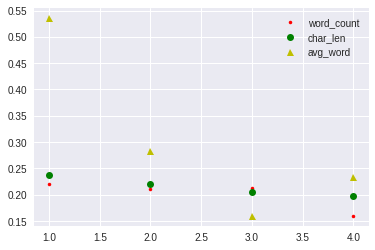

In [7]:
include_word_features(train, 'description')
word_feature_analysis(train)

In [8]:
#looks like the mean of the avg_word is highly differentiable for the classes 
#so we will include that as features and will discard others

# performing text cleaning

import nltk
from nltk.corpus import stopwords
from textblob import Word
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
sw = set(stopwords.words('english'))

#this function removes all the stopwords and punctuation marks from the sentences and also lemmatizes the words
def clean_text(sentence):
  sentence =  re.sub('[~`!@#$%^&*():;"{}_/?><\|.,`0-9]', '', sentence.replace('-', ' '))
  words = nltk.word_tokenize(str(sentence).lower())
  words = [Word(word).lemmatize() for word in words if not word in sw]
  sentence = ' '.join(words)
  return sentence



[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [0]:
# applying text cleaning to both the title and descriptions of news
train['title'] = train['title'].apply(lambda x: clean_text(x))
train['description'] = train['description'].apply(lambda x: clean_text(x))

In [0]:
# creating numpy arrays from the dataframe and vectorizing title and description 
# the value of max_df is lept because all the classes are equally distributed contributing 25% to the whole dataset so we will discard those words which are present in more than 30% of all the samples
description = train['description'].iloc[:].values
title = train['title'].iloc[:].values
avg = train['avg_word'].iloc[:].values
avg = (avg - np.mean(avg))/np.std(avg)
from sklearn.feature_extraction.text import TfidfVectorizer
t_vec = TfidfVectorizer(max_features = 400, ngram_range = (1, 2), max_df = 0.3)
d_vec = TfidfVectorizer(max_features = 5000, ngram_range = (1, 3), max_df = 0.3)
title = t_vec.fit_transform(title).toarray()
description = d_vec.fit_transform(description).toarray()

In [0]:
# this is a scheme which generally works, we increase the weights of headlines by an integer so as to give them more importance than the text blocks
# i have previously used this technique to increase the performance
X = np.concatenate([5*title, description, avg.reshape((train_length, 1))], axis = 1)
y = train['class'].iloc[:].values

In [0]:
del title, description 
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()

In [0]:
# applying the same functions to the test set as well 
test = pd.read_csv('test.csv', header = None)
test.columns = ['class', 'title', 'description']
include_word_features(test, 'description')
test['title'] = test['title'].apply(lambda x: clean_text(x))
test['description'] = test['description'].apply(lambda x: clean_text(x))
title = test['title'].iloc[:].values
description = test['description'].iloc[:].values
avg = test['avg_word'].iloc[:].values
avg = (avg - np.mean(avg))/np.std(avg)
title = t_vec.transform(title).toarray()
description = d_vec.transform(description).toarray()
x_test = np.concatenate((5*title, description, avg.reshape((len(test), 1))), axis = 1)
y_test = test['class'].iloc[:].values

In [14]:
# fitting the model and checking the accuracy
model.fit(X, y)
y_hat = model.predict(x_test)
print('accuracy is :', (y_test == y_hat).sum()/len(y_hat))

accuracy is : 0.8568421052631578
